In [9]:
import numpy as np
import csv
#import networkx as nx
#import nltk
#from nltk.util import ngrams
import matplotlib.pyplot as plt
from itertools import combinations, combinations_with_replacement
#import torch
#from torch.utils.data import DataLoader
#from scipy import spatial
#from sklearn.metrics.pairwise import cosine_similarity
import moseq2_viz
from moseq2_viz.util import parse_index
from moseq2_viz.model.util import (get_transition_matrix,
                                   parse_model_results,
                                   results_to_dataframe,
                                   relabel_by_usage, get_syllable_statistics)
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models import Phrases
import gensim.models.phrases
import operator
from tqdm.notebook import tqdm
import seaborn as sns
import pdb
import os
os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES']='4'

In [ ]:
vdir = '/cs/usr/ricci/data/abraira/moseq-nlp/models'
import glob

timepoints = ['p10','p12','p14','p21','p28','p35','p60','p90']

best_models = []
for tp in timepoints:
    tp_dir = os.path.join(vdir, tp)
    pdb.set_trace()
    all_model_paths = glob.glob(os.path.join(tp_dir, '*[!log]'))
    pdb.set_trace()
    all_accs = []
    for fp in all_model_paths:
        acc = np.load(os.path.join(fp,'accuracy.npy'))
    ind = np.argmax(acc)
    best_model_path = all_model_paths[ind]
    model_pars = best_model_path.split('_')
    emissions = (model_pars[2] == 'True')
    embedding_window = int(model_pars[4])
    embedding_dim = int(model_pars[6])
    DE = DocumentEmbedding(2, embedding_dim=embedding_dim, embedding_window=embedding_window, embedding_epochs=50)
    best_models.append(DE.load(best_model_path))

In [3]:
class FreePhrases(object):
    def __init__(self, corpus, min_count=1, threshold=.01):
        
    def get_free_ngrams(self, list_of_strings,n,vocab=None, replacement=False):
        comb = combinations if replacement is False else combinations_with_replacement
        free_ngrams = {}
        if vocab is not None:
            free_ngrams = {comb : 0 for comb in combinations_with_replacement(vocab,n)}
            for i in range(len(list_of_strings) - (n-1)):
                subseq = list_of_strings[i:i+n]
                sorted_subseq = np.sort([int(syl) for syl in subseq])
                key = tuple([str(p) for p in sorted_subseq])
                free_ngrams[key] += 1
        return free_ngrams 

IndentationError: expected an indented block (3961483155.py, line 4)

In [4]:
# Note: custom_labels are for custom groupings of data (currently only implemented for SCI data)

super_dir = '/cs/usr/ricci/data/abraira' # Where all your data is stored
experiment = '2021-06-04_P4_C2_SCI_timecourse' # Sub-folder name
use_custom_labels = True

timepoints = [10,12,14,21,28,35,60,90]

model_files = [os.path.join(super_dir, experiment, 'P{}-sex_rST_model_1000.p'.format(t)) for t in timepoints]
index_files = [os.path.join(super_dir, experiment, 'moseq2-index.P{}.grouped-sex.yaml'.format(t)) for t in timepoints]
max_syllable = 100

groups = ['P4_C2_SCI_P10_M',
          'Control_P10_F', 'Control_P10_M',
          'P4_C2_SCI_P12_M', 'P4_C2_SCI_P12_F',
          'Control_P12_M', 'Control_P12_F',
          'P4_C2_SCI_P14_M', 'P4_C2_SCI_P14_F',
          'Control_P14_F', 'Control_P14_M',
          'P4_C2_SCI_P21_M', 'P4_C2_SCI_P21_F',
          'Control_P21_M', 'Control_P21_F',
          'P4_C2_SCI_P28_M', 'P4_C2_SCI_P28_F',
          'Control_P28_F', 'Control_P28_M',
          'P4_C2_SCI_P35_M','P4_C2_SCI_P35_F',
          'Control_P35_M', 'Control_P35_F',
          'P4_C2_SCI_P60_M', 'P4_C2_SCI_P60_F',
          'Control_P60_M',
          'P4_C2_SCI_P90_M', 'P4_C2_SCI_P90_F',
          'Control_P90_M']
if not use_custom_labels:
    custom_labels = []
    custom_label_names = groups
else:
    custom_labels = [0,1,1,0,0,1,1,0,0,1,1,2,2,3,3,2,2,3,3,2,2,3,3,4,4,5,4,4,5]
    custom_label_names = ['Early injury', 'Early control', 'Mid injury', 'Mid control', 'Late injury', 'Late control']

palette = sns.color_palette(['#f06493', '#35fab3', '#647aa3', '#020887', '#ff0000'])


In [5]:

_, sorted_index = parse_index(index_files[1])
ms_model = parse_model_results(model_files[1], sort_labels_by_usage=True, count='usage')
labels = ms_model['labels']
label_group = [sorted_index['files'][uuid]['group'] for uuid in ms_model['keys']]

print(label_group)
['Control_P10_F', 'P4_C2_SCI_P10_M', 'Control_P10_M', 'Control_P10_F', 'Control_P10_M', 'P4_C2_SCI_P10_M', 'P4_C2_SCI_P10_M', 'P4_C2_SCI_P10_M']


FileNotFoundError: [Errno 2] No such file or directory: '/media/data_cifs/matt/abraira_data/2021-06-04_P4_C2_SCI_timecourse/moseq2-index.P12.grouped-sex.yaml'

In [6]:
# Process data
# Data to store
labels = []
label_group = []
for (index_file, model_file) in zip(index_files, model_files):
    _, sorted_index = parse_index(index_file)
    ms_model = parse_model_results(model_file, sort_labels_by_usage=True, count='usage')
    labels.append(ms_model['labels'])
    label_group.append([sorted_index['files'][uuid]['group'] for uuid in ms_model['keys']])
    
labels      = [item for sublist in labels for item in sublist]
label_group = [item for sublist in label_group for item in sublist]

# tmp = []
# for lbg in label_group:
#     if lbg not in tmp:
#         tmp.append(lbg)
#     else:
#         continue
# print(tmp)
# pdb.set_trace()

use_BMS_custom_labels = False
bms_custom_labels = [0,0,0,1,1,1,2,2,2]
tm_vals = []
truncated_tm_vals = []
group_vals = []
group_labels = []
usage_vals = []
frames_vals = []
sentences = []
bigram_sentences = []
sentence_strings = []
sentence_groups = {group : [] for group in groups}
bad_syllables = [-5] # <---- Syllables to omit
for i, (l, g) in tqdm(enumerate(zip(labels, label_group))):
    
    if g not in groups and g != 'M_ukn':
        pdb.set_trace()
        raise ValueError('Group name in data not recognized. Check the group names you specified!')
    elif g == 'M_ukn':
        continue
    group_vals.append(g)

    # Label data using default or custom labels
    if len(custom_labels) == 0 and not use_BMS_custom_labels:
        group_labels.append(groups.index(g))
    elif not use_BMS_custom_labels:
        group_labels.append(custom_labels[groups.index(g)])
    else:
        group_labels.append(bms_custom_labels[BMS_Right[i] - 1])

    # Get transitions
    tm = get_transition_matrix([l], combine=True, max_syllable=max_syllable)
    tm_vals.append(tm.ravel())

    # Get usages
    u, _ = get_syllable_statistics(l, count='usage')
    u_vals = list(u.values())[:max_syllable]
    total_u = np.sum(list(u_vals))
    usage_vals.append(np.array(u_vals) / total_u)

    # Get frame values
    f, _ = get_syllable_statistics(l, count='usage')
    total_f = np.sum(list(f.values()))
    frames_vals.append(np.array(list(f.values())) / total_f)

    # Get emissions
    l = list(filter(lambda a: a not in bad_syllables, l))
    np_l = np.array(l)
    cp_inds = np.concatenate((np.where(np.diff(np_l) != 0 )[0],np.array([len(l) - 1])))
    syllables = np_l[cp_inds]
    sentence = [str(syl) for syl in syllables]
    sentences.append(sentence)
    sentence_strings.append(' '.join(sentence))
    sentence_groups[g].append(sentence)

    bigram_model = Phrases(sentence, min_count=1, threshold=1, scoring='npmi')
    bgs = bigram_model[sentence]
#     print(len([phr for phr in bgs if '_' in phr]))
    bigram_sentences.append(bgs)
        
# Post-processing including truncation of transitions
# Truncated transitions
tm_vals = np.array(tm_vals)
top_transitions = np.argsort(tm_vals.mean(0))[-max_syllable:]
truncated_tm_vals = tm_vals[:,top_transitions]

# Make numpy
usage_vals = np.array(usage_vals)
frames_vals = np.array(frames_vals)
num_animals = len(sentences)

np_g = np.array(group_labels)
group_sizes = [sum(np_g == g) for g in np.unique(np_g)]
lb_ind = np.argsort(np_g)

In [7]:
# Turn emissions per animal ("sentences") into TaggedDocument obejcts
use_bigrams = False
which_sentences = bigram_sentences if use_bigrams else sentences
documents = [TaggedDocument(sent, [i]) for i, sent in enumerate(which_sentences)]

In [8]:
dim = max_syllable # Dimension of embedding space
window = 4 # Window size for context (this is left and right, so total size is 2*window)

# Initialize and train two models on the documents. Embeddings will be averaged, which is standard. 
# Note: min_count = <min_count> omits words with usages less than <min_count>
model1 = Doc2Vec(documents, dm=1, epochs=150, vector_size=dim, window=window, min_count=1, workers=1)
model2 = Doc2Vec(documents, dm=0, epochs=150, vector_size=dim, window=window, min_count=1, workers=1)

In [9]:
# Infer embeddings per document per model and then average. 
which_sentences = bigram_sentences if use_bigrams else sentences

E1 = [model1.infer_vector(sent) for sent in which_sentences]
E2 = [model2.infer_vector(sent) for sent in which_sentences]
E = [.5 * (em1 + em2) for (em1, em2) in zip(E1, E2)]

[  0  22  42  75 102 116 125]


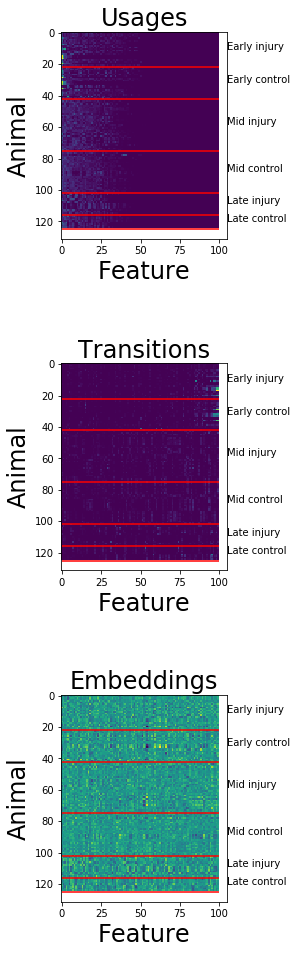

In [10]:
# Plot all three representation types: usages, transitions, embeddings

fig, axes = plt.subplots(3,1, figsize = (8,16))
line_heights = np.concatenate((np.array([0]), np.cumsum(group_sizes)))
print(line_heights)
for ax, ti, rep in zip(axes, ['Usages', 'Transitions','Embeddings'],[usage_vals, truncated_tm_vals, E]):
    np_rep = np.array(rep)
    ax.imshow(np_rep[lb_ind,:])
    ax.set_title(ti, fontsize=24)
    ax.set_xlabel('Feature', fontsize=24)
    ax.set_ylabel('Animal', fontsize=24)
    ax.hlines(line_heights[1:], 0, max_syllable, colors='r')
    for s, sl in enumerate(custom_label_names):
        ax.text(float(max_syllable + 5), .5*(line_heights[s] + line_heights[s+1]), sl)
plt.subplots_adjust(hspace=.6)
plt.show()
plt.close()

In [33]:
from sklearn.linear_model import LogisticRegression
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

K = 1 # K-fold cross-validation
C = 1e-3 #9e-1 # C is inversely proporitional to L2 regularization
# all_C = np.logspace(-4,4,num=9)
penalty = 'none'
all_C = [1e0]

# Permute training data
perm_ind = np.random.permutation(num_animals)
perm_embeddings = np.array(E)[perm_ind,:]
perm_usages = usage_vals[perm_ind,:]
perm_trans  = truncated_tm_vals[perm_ind,:]
perm_labels = np.array(group_labels)[perm_ind]
# perm_labels = np.array(BMS_Right)[perm_ind]

accs_per_C = []
accs_per_rep = []
accs = [[],[],[]]
names = ['Usages', 'Transitions', 'Embeddings']
# For each representation
seed=0
for C in tqdm(all_C):
    seed+=1
    for j, (nm, rep) in enumerate(zip(names,[perm_usages, perm_trans, perm_embeddings])):
        # For each split
        for i in range(int(num_animals / float(K))):
            # New split of data and labels
            shifted_rep = np.roll(rep, i*K, axis=0)
            shifted_labels = np.roll(perm_labels, i*K, axis=0)

            # Split into train and test
            train_X, train_y = shifted_rep[K:,:], shifted_labels[K:]
            test_X, test_y = shifted_rep[:K,:], shifted_labels[:K]

            # Load and train classifier
            clf = LogisticRegression(random_state=seed,solver='lbfgs',class_weight='balanced',
                                     multi_class='auto', tol=1e-5, max_iter=1000).fit(train_X, train_y)
            # Predict on held-out data
            y_pred = clf.predict(test_X)
            # Store average accuracy on test set for this split for this representation
            accs[j].append(np.mean(1*(y_pred == test_y)))
    accs_per_C.append(np.array(accs).mean(-1))
#         accs_per_rep.append(np.mean(accs[j]))
#         print('Testing accuracy for {}: {}'.format(nm, np.mean(accs[j])))
# print(accs_per_C)

0.32 1.0
0.456 1.0
0.536 1.0


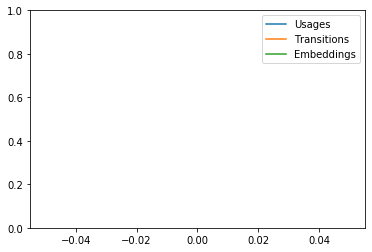

[1.0]


In [34]:
# plt.bar(np.arange(3),accs_per_rep)
# plt.show()
# plt.close()
# print(accs_per_C)
tmp = np.array(accs_per_C)
for res in tmp.T:
    print(np.max(res), all_C[np.argmax(res)])

plt.plot(accs_per_C)
plt.ylim([0,1.0])
plt.legend(['Usages', 'Transitions', 'Embeddings'])
plt.show()
plt.close()
print(all_C)
 

In [18]:
from gensim.models.phrases import Phrases

# How many total phrases to keep track of per n-gram model
num_phrases = 10

# Let's just look at 2-3-4-grams 
all_bigram_models = []
all_bigram_sentences = []
all_trigram_models = []

# For each experimental group
which_labels = custom_label_names if use_custom_labels else groups

for l, label in enumerate(which_labels):
    print(label)
    
    # Get emissions for this group
    if not use_custom_labels:
        group_sentences = sentence_groups[label]
    else:
        group_sentences = []
        custom_groups = [groups[i] for i,j in enumerate(custom_labels) if j == l]
        for cgroup in custom_groups:
            group_sentences += sentence_groups[cgroup]
    
    # Bigrams: Omit emissions with fewer than min_count occurences. Threshold=.01 essentially means that all grams will be scored and returned
    bigram_model = Phrases(group_sentences, min_count=10, threshold=.01)
    bigram_sentences = [sent for sent in bigram_model[group_sentences]] # New emissions with bi-grams condensed to single tokens
    all_bigram_models.append(bigram_model) # store bigram model for this animal.
    
    # Do same thing, but now on the bigram sentences. This gives 3 and 4 grams (compositions of 1,2-grams)
    trigram_model = Phrases(bigram_sentences, min_count=10, threshold=.01)
    all_trigram_models.append(trigram_model)
    
    # Now print results
    for which_sentences, model in zip([group_sentences, bigram_sentences],[bigram_model, trigram_model]):
        scores  = np.array([score  for (phrase, score) in model.find_phrases(which_sentences).items()])
        phrases = [phrase for (phrase, score) in model.find_phrases(which_sentences).items()]
        median_score = np.median(scores)

        total_score = sum(scores)
        score_inds = np.argsort(scores)[::-1]
        sorted_scores  = scores[score_inds]
        sorted_phrases = [phrases[i] for i in score_inds]
                
        top_scores = sorted_scores[:num_phrases]
        top_phrases = sorted_phrases[:num_phrases]

        print('Top phrases n-gram/1-gram ratios')
        
        for phr, sc in zip(top_phrases, top_scores):
            print('{}  : {}'.format(phr,sc))
        print('\n')

Early injury
Top phrases n-gram/1-gram ratios
45_38  : 3.772521923996811
38_16  : 1.7560842220399235
34_50  : 1.7052252252252251
47_22  : 1.2606060606060605
27_42  : 1.2206986061734666
22_47  : 1.0687747035573123
16_38  : 0.9858718439522377
50_34  : 0.9744144144144145
21_44  : 0.8369444100532375
46_13  : 0.793168633074767


Top phrases n-gram/1-gram ratios
33_34_33_34  : 90.8928
20_25_20_25  : 74.80888888888889
25_20_25_20  : 58.44444444444444
0_36_0_25  : 47.45864661654135
25_0_36_0  : 34.894348894348894
16_38_16  : 12.076530612244897
6_7_6_7  : 10.237889273356402
38_16_38_16  : 9.66122448979592
16_38_16_38  : 9.131944444444445
14_11_14_11  : 8.416


Early control
Top phrases n-gram/1-gram ratios
34_50  : 2.584798534798535
38_16  : 2.146921017402945
50_34  : 2.114835164835165
16_38  : 1.4312806782686303
20_33  : 1.3683112306408236
47_22  : 1.3176994180075317
42_23  : 1.283
45_38  : 1.218423551756885
23_30  : 1.1892335115864527
30_23  : 0.875589508530685


Top phrases n-gram/1-gram rat

In [28]:
timepoints = ['p10', 'p12', 'p14', 'p21','p28','p35','p60','p90']
conditions = ['Injury', 'Control']
ngrams = ['2gram', '3+grams']
num_syl = 70

for tp in timepoints:
    for cond in conditions:
        for n, ng in enumerate(ngrams):
            all_ng_str = []
            if n < 1:
                for i in range(10):
                    ngram = [0,0]
                    while ngram[0] == ngram[1]: 
                        ngram = [np.random.randint(num_syl), np.random.randint(num_syl)]
                    ngram_str = '_'.join([str(x) for x in ngram])
                    all_ng_str.append(ngram_str)
                print('Timepoint:' + tp)
                print('Condition:' + cond)
                print(ng + '\n')
                for j, ngs in enumerate(all_ng_str):
                    print(ngs + ': ' + str(np.random.rand(1) * (1 - .1*j)))
                print('\n')
            else:
                for i in range(10):
                    three_or_four = (np.random.rand(1) < .5)
                    num = 3 if three_or_four else 4
                    two_pair = (np.random.rand(1) < .5)
                    ngram = [0,0,0] if three_or_four else [0,0,0,0]
                    while 0 in list(np.diff(np.array(ngram))): 
                        ngram = [np.random.randint(num_syl) for _ in range(num)]
                    if two_pair:
                        ngram = ngram[:2] + ngram[:2]
                    ngram_str = '_'.join([str(x) for x in ngram])
                    all_ng_str.append(ngram_str)
                print('Timepoint:' + tp)
                print('Condition:' + cond)
                print(ng + '\n')
                for j, ngs in enumerate(all_ng_str):
                    print(ngs + ': ' + str((np.random.rand(1) * (2 - .2*j))))
                print('\n')

Timepoint:p10
Condition:Injury
2gram

38_57: [0.63752464]
55_48: [0.37900153]
0_40: [0.34428694]
33_44: [0.19516382]
63_38: [0.23259494]
59_8: [0.09824736]
36_47: [0.17013666]
16_32: [0.01651307]
55_24: [0.10907959]
61_68: [0.06191102]


Timepoint:p10
Condition:Injury
3+grams

4_28_4_28: [1.37863064]
58_45_48_40: [0.40292131]
64_58_64_58: [0.43493636]
58_32_22_28: [0.9105228]
57_65_57_65: [0.82153321]
30_35_30_35: [0.04912605]
59_36_49: [0.18831921]
59_51_59_51: [0.15557274]
66_38_66_38: [0.1272717]
12_53_15_18: [0.06526615]


Timepoint:p10
Condition:Control
2gram

6_59: [0.27747636]
51_13: [0.68755929]
10_27: [0.40116334]
52_67: [0.4023779]
20_67: [0.55355859]
30_42: [0.38147175]
39_37: [0.13069792]
41_15: [0.0499727]
42_24: [0.18190158]
5_54: [0.04389174]


Timepoint:p10
Condition:Control
3+grams

16_53_16_53: [1.75039217]
67_54_10_50: [1.15464243]
67_63_67_63: [0.4289769]
62_66_54: [0.12419916]
46_39_46_39: [0.07902369]
55_68_55_68: [0.20842895]
59_26_10: [0.71111762]
4_18_42_63: [0